In [1]:
import pandas as pd
from constants import *
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import numpy as np

In [2]:
# to limit how much data is read in, I use chunksize to load the CSV in smaller chunks, one at a time
# then filter for post 2021 dates only

data_chunks = []
chunksize = 10000

for chunk in pd.read_csv('311_Data.csv', chunksize=chunksize, 
                         parse_dates=['create_date_et'],
                         index_col='_id'):
   
    filtered_chunk = chunk[chunk['create_date_et'] >= '2021-01-01']
    data_chunks.append(filtered_chunk)

filtered_data = pd.concat(data_chunks, ignore_index=True)

In [3]:
print(f'There are {len(filtered_data)} rows. The columns are:')
filtered_data.columns

There are 371801 rows. The columns are:


Index(['group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy'],
      dtype='object')

In [4]:
# Calculate total and percent of missing values per column
missing_info = pd.DataFrame({
    'Missing Values': filtered_data.isna().sum(),
    'Percent Missing': filtered_data.isnull().mean() * 100
})
missing_info = missing_info.sort_values(by='Percent Missing', ascending=False)
missing_info


,Missing Values,Percent Missing
cross_street,335872,90.336497
street,166371,44.747325
cross_street_id,163823,44.062012
street_id,163823,44.062012
census_tract,142369,38.291721
closed_date_et,53511,14.392377
closed_date_utc,53511,14.392377
neighborhood,20388,5.483579
police_zone,20375,5.480082
ward,20350,5.473358


In [5]:
filtered_data.dtypes

group_id                      int64
num_requests                  int64
parent_closed                object
status_name                  object
status_code                   int64
dept                         object
request_type_name            object
request_type_id               int64
create_date_et       datetime64[ns]
create_date_utc              object
last_action_et               object
last_action_utc              object
closed_date_et               object
closed_date_utc              object
origin                       object
street                       object
cross_street                 object
street_id                   float64
cross_street_id             float64
city                         object
neighborhood                 object
census_tract                float64
council_district            float64
ward                        float64
police_zone                 float64
latitude                    float64
longitude                   float64
geo_accuracy                

# Data Cleaning

## Column Drop and Imputation Justification
* The columns with '_utc' endings have the Eastern Time zone equivalent, and add little value to analysis,  expecially in ML settings where such redudancies can lead to multicollinearity
* The 'cross_street' column has 90% of its values missing, thus imputation techniques would likely do more damage than good.
* The 'geo_accuracy' is a column that explains whether the coordinates are exact, approxiate, out of bounds, null, or redacted. This information is helpful for understanding the raw data, but serves no purpose in ML contexts since the scope of 'approximate' is undefined and the redacted entries are for de-identification purposes. 

For the street, street_id, cross_street_id, and census_tract columns, which are medium-sparsely populated, I will implement an imputation method based on the most common (mode) value within the same neighborhood

In [6]:
filtered_data.geo_accuracy.unique()

array(['NULL_COORDINATES', 'EXACT', 'APPROXIMATE', 'OUT_OF_BOUNDS',
       'REDACTED'], dtype=object)

In [7]:
filtered_data.drop(columns=['create_date_utc','closed_date_utc','last_action_utc', 'cross_street','geo_accuracy'],inplace=True)

def impute_by_group_mode(df, target_col, group_col):
    """
    Imputes missing values in `target_col` using the most frequent value (mode)
    within each group in `group_col`.

    Parameters:
    - df (pd.DataFrame): Your dataset
    - target_col (str): The column to fill (e.g., 'street')
    - group_col (str): The group used for imputation (e.g., 'neighborhood')

    Returns:
    - pd.Series: The imputed column
    """
    def mode_or_nan(group):
        '''Get the mode of a group if there’s a mode, else return NaN (edge case)'''
        mode_vals = group.mode()
        return mode_vals.iloc[0] if not mode_vals.empty else np.nan

    return df.groupby(group_col)[target_col].transform(
        #.transform is needed to align the returned Series with the original DataFrame
        lambda group: group.fillna(mode_or_nan(group))
    )
filtered_data['street'] = impute_by_group_mode(filtered_data, 'street', 'neighborhood')
filtered_data['street_id'] = impute_by_group_mode(filtered_data, 'street_id', 'neighborhood')
filtered_data['cross_street_id'] = impute_by_group_mode(filtered_data, 'cross_street_id', 'neighborhood')
filtered_data['census_tract'] = impute_by_group_mode(filtered_data, 'census_tract', 'neighborhood')

In [8]:
(filtered_data.isnull().mean() * 100).sort_values(ascending=False)[0:10]

closed_date_et      14.392377
street_id            5.483579
census_tract         5.483579
neighborhood         5.483579
cross_street_id      5.483579
street               5.483579
police_zone          5.480082
ward                 5.473358
council_district     5.248507
longitude            4.910423
dtype: float64

**There are still ~20% of observations with at least 1 NaN, thus dropping them is too costly. Instead, I will group the observations according to request_type_id, city, and neighborhood, and use forward propagation to fill in the missing values. The logic here is:**

* Requests of the same type in the same area likely share metadata (like street_id, census_tract, etc.) 
* The data has a chronological component (or is at least somewhat sorted logically)

This approach keeps context by filling missing values with info from similar request patterns, and is less aggressive than using global modes or dropping rows.

In [9]:
filtered_data.sort_values(by=['create_date_et','request_type_id', 'city', 'neighborhood'], inplace=True)

cols_to_fill = ['street', 'street_id', 'census_tract', 'neighborhood','cross_street_id', 'police_zone', 'ward', 'council_district']

# Group by relevant features and forward-fill
filtered_data[cols_to_fill] = (filtered_data.groupby(['request_type_id', 'city'])[cols_to_fill].ffill())
(filtered_data.isnull().mean() * 100).sort_values(ascending=False)[0:10]

closed_date_et     14.392377
longitude           4.910423
latitude            4.910423
police_zone         2.497573
street_id           2.496497
census_tract        2.496497
neighborhood        2.496497
cross_street_id     2.496497
street              2.496497
ward                2.495959
dtype: float64

**For the remaining features, I input 'unknown' for nominal categories, the present date for 'closed_date_et', and 0 for the id**

In [10]:
filtered_data[['police_zone', 'council_district', 'street', 'ward', 'neighborhood','census_tract','dept']] = (
    filtered_data[['police_zone', 'council_district', 'street', 'ward', 'neighborhood','census_tract','dept']]
    .fillna('unknown'))
filtered_data.fillna(value={'closed_date_et':pd.Timestamp.now(),'street_id':0,'cross_street_id':0},inplace=True)

In [11]:
(filtered_data.isnull().mean() * 100).sort_values(ascending=False)[0:10]

longitude           4.910423
latitude            4.910423
street              0.000000
police_zone         0.000000
ward                0.000000
council_district    0.000000
census_tract        0.000000
neighborhood        0.000000
city                0.000000
cross_street_id     0.000000
dtype: float64

## Data Transformation

**The 'request_type_name' column has values such as "Thank you", "Thank You - 311",	"Thank You - Police", "Thank You - EMS". One potential alternative is to combine all this into the "Thank you Umbrella". The drawback is that they have different codes for the department receiving the codes, and this information can be useful for highlighting the kinds of services that a ward or neighborhood receives**

### Datetime

In [12]:
# filtered_data['request_type_name'] = filtered_data['request_type_name'].str.replace(r'(?i)^Thank\s+You\s.*$', 'Thank You', regex=True)

# ensure that all the time columns are converted to datetime:
for col in ['create_date_et', 'last_action_et', 'closed_date_et']:
    filtered_data[col] = pd.to_datetime(filtered_data[col], errors='coerce')

# Convert 'parent_closed' boolean column to numbers
filtered_data['parent_closed'] = filtered_data['parent_closed'].map({'f':0,'t':1})

### Categorical Mapping of Origin

In [13]:
# Apply Dictionary to origin column, and generate the new dictionary dynamically
origin_dictionary = {origin: index for index, origin in enumerate(filtered_data['origin'].unique())}

# Function to read the current constants.py and update it
def update_constants(new_dict, dict_name, file_path):
    '''This function is a dynamic function to either make a dictionary or update an existing dictionary
    in the constants.py file. The dictionary maps each value in the origin column to a number, since the
    origin column details where the 311 Data was collected from (call center, website, email, text, etc)'''
    
    try:
        # Read the current file content
        try:
            with open(file_path, 'r') as file:
                content = file.read()
        except FileNotFoundError:
            content = ""

        lines = content.splitlines()

        # Look for the existing line for the dict
        updated = False
        for i, line in enumerate(lines):
            if line.strip().startswith(f"{dict_name} ="):
                lines[i] = f"{dict_name} = {new_dict}"
                updated = True
                break

        # If the dictionary wasn't found, append it
        if not updated:
            lines.append(f"{dict_name} = {new_dict}")

        # Write the updated lines back to the file
        with open(file_path, 'w') as file:
            file.write('\n'.join(lines) + '\n')

        print(f"{dict_name} successfully updated in {file_path}.")

    except Exception as e:
        print(f"Error updating constants: {e}")


# Use the function to update the ORIGIN_DICT in constants.py
update_constants(origin_dictionary, 'origin_dictionary', 'constants.py')
# Apply the dictionary mapping to encode 'origin'
filtered_data['origin'] = filtered_data['origin'].map(origin_dictionary)


origin_dictionary successfully updated in constants.py.


### GeoSpatial Data Imputation
- The 'city' column has no null values. Thus, for each city, compute the average latitude and longitude.
- For rows where either latitude or longitude is missing, rather than dropping the rows, fill them using the average coordinates for that city.

In [14]:
# There are 3 rows with "City of Pittsburgh" as the city designation. I change those to just "Pittsburgh"
filtered_data['city'] = filtered_data['city'].replace('City of Pittsburgh', 'Pittsburgh')

# Step 1: Calculate average coordinates per city (excluding NaNs)
city_avg_coords = filtered_data.groupby('city')[['latitude', 'longitude']].mean()

# to optimize the code, only check the rows with missing coordinates
missing_coords = filtered_data[filtered_data[['latitude', 'longitude']].isna().any(axis=1)].copy()
valid_coords = filtered_data.dropna(subset=['latitude', 'longitude'])

# Step 3: Define the imputation function
def impute_coords(row):
    '''The function checks for missing latitude or longitude in each row and fills those missing values using the 
    average coordinates for the corresponding city.'''
    city = row['city']
    if city in city_avg_coords.index:
        if pd.isna(row['latitude']):
            row['latitude'] = city_avg_coords.loc[city, 'latitude']
        if pd.isna(row['longitude']):
            row['longitude'] = city_avg_coords.loc[city, 'longitude']
    return row

# Step 4: Impute only missing rows
imputed_coords = missing_coords.apply(impute_coords, axis=1)

# Step 5: Combine the DataFrames back together
filtered_data= pd.concat([valid_coords, imputed_coords], ignore_index=True)

# just to reclaim memory
del valid_coords
del imputed_coords

In [15]:
filtered_data.isna().sum()

group_id             0
num_requests         0
parent_closed        0
status_name          0
status_code          0
dept                 0
request_type_name    0
request_type_id      0
create_date_et       0
last_action_et       0
closed_date_et       0
origin               0
street               0
street_id            0
cross_street_id      0
city                 0
neighborhood         0
census_tract         0
council_district     0
ward                 0
police_zone          0
latitude             0
longitude            0
dtype: int64

## What is the Distribution of Requests? Does it differ by Year?

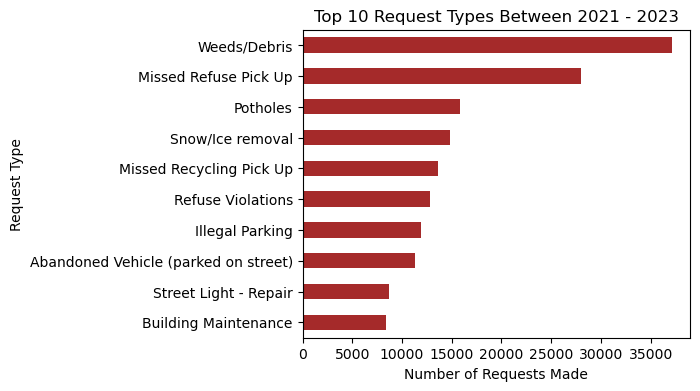

In [16]:
n = 10  # You can change this to the desired number of top values

# Extract the year from 'create_date_et'
filtered_data['year'] = filtered_data['create_date_et'].dt.year
request_type_counts = filtered_data['request_type_name'].value_counts()
top_request_types = request_type_counts.head(n).sort_values(ascending=True)
plt.figure(figsize=(5, 4))
top_request_types.plot(kind='barh', color='brown')

plt.xlabel('Number of Requests Made')
plt.ylabel('Request Type')
plt.title(f'Top {n} Request Types Between 2021 - 2023')
plt.show()

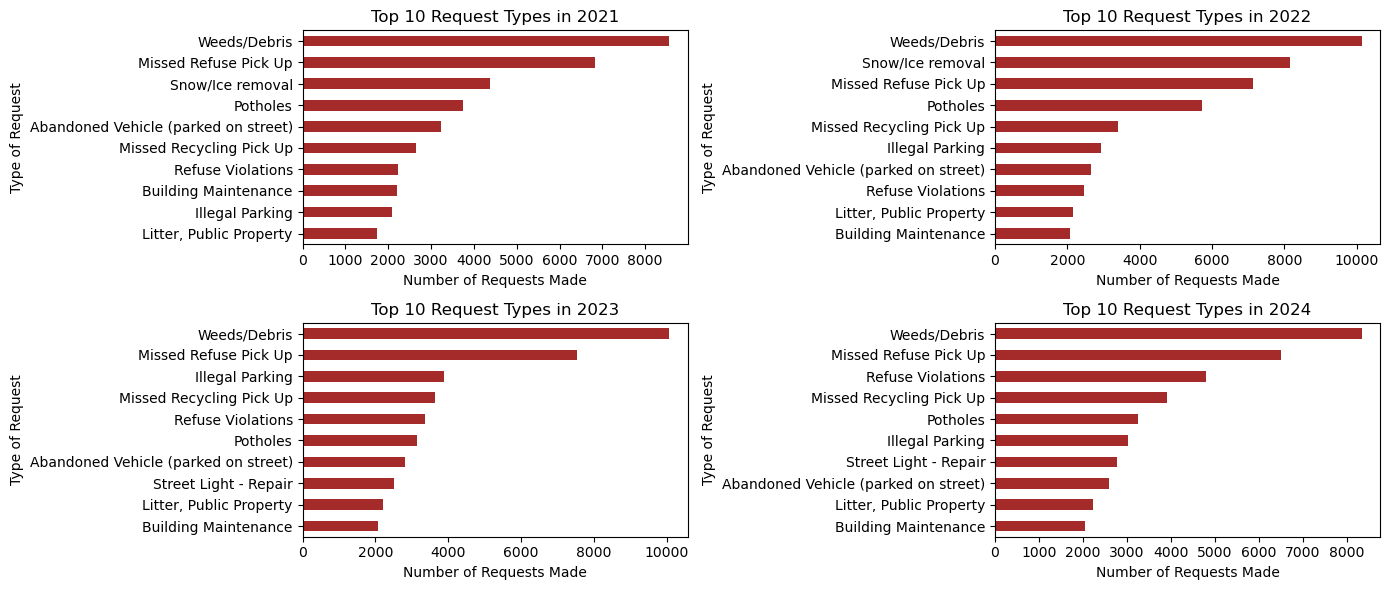

In [17]:
# Create a 2x2 grid of subplots (2 rows, 2 columns), and flatten the axes for easy iteration
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes = axes.flatten()

for i, year in enumerate(filtered_data['year'].unique()):
    yearly_requests = filtered_data[filtered_data['year'] == year]
    request_type_counts = yearly_requests['request_type_name'].value_counts()
    top_request_types = request_type_counts.head(n).sort_values(ascending=True)

    # Plotting on the respective subplot (axes[i])
    top_request_types.plot(kind='barh', color='brown', ax=axes[i])

    axes[i].set_xlabel('Number of Requests Made')
    axes[i].set_ylabel('Type of Request')
    axes[i].set_title(f'Top {n} Request Types in {year}')

plt.tight_layout()
plt.show()

## What is the Geospatial Distribution of the 311 Calls and Reports?

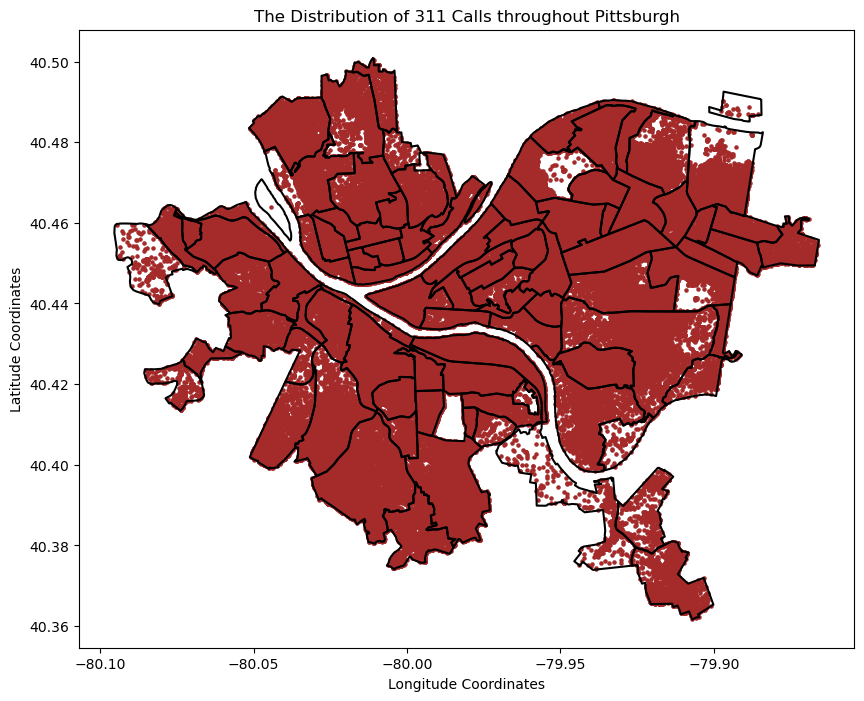

In [18]:
pittsburgh = gpd.read_file('pittsburgh.geojson')
report_locations = gpd.GeoDataFrame(filtered_data, 
                                geometry=gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude),
                                crs=pittsburgh.crs)

report_locations_within_pittsburgh = report_locations[report_locations.geometry.within(pittsburgh.geometry.union_all())]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
pittsburgh.geometry.boundary.plot(ax=ax, color="black")
report_locations_within_pittsburgh.plot(ax=ax, color='brown', marker='o', markersize=5)
plt.title('The Distribution of 311 Calls throughout Pittsburgh')
plt.xlabel('Longitude Coordinates')
plt.ylabel('Latitude Coordinates')
plt.show()

# Prepare Data for Clustering

## Visual Exploration

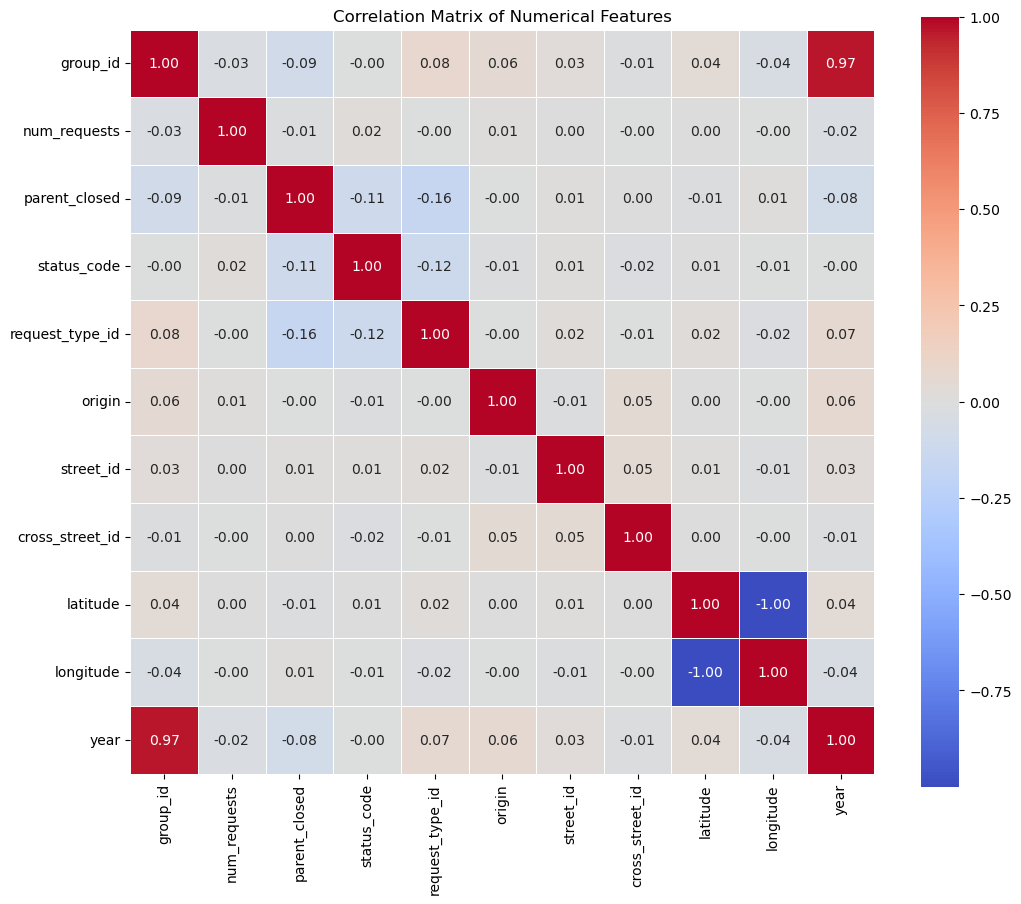

In [19]:
#numeric_df = filtered_data.select_dtypes(include=['number'])
correlation_matrix = filtered_data.select_dtypes(include=['number']).corr() #the include=['number'] filters numeric columns only

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


**This doesn't provide much information, particualy because a lot of the granular details needed to inform our model are in the categorical columns**

# Feature Discovery for Clustering

**Remove status and request_type names to avoid redundancy since 'status_code' and 'request_type_id' already contain that information**

In [20]:
def generate_and_store_mapping(filtered_data, column_pairs, constants_file='constants.py'):
    '''
        This function takes any columns that are redundant (such as columns with names and corresponding values), 
        creates a dictionary of the names and value pairs, and drops the names column. It also appends a dictionary 
        as a reference in the constants.py file.
    '''

    for key_col, value_col in column_pairs:
        # Generate the mapping
        mapping_dict = (filtered_data[[key_col, value_col]].drop_duplicates().set_index(key_col)[value_col].to_dict())
        
        # Create the variable name (e.g. status_code_to_status_name)
        variable_name = f"{key_col}_to_{value_col}"
        
        # Check if the variable already exists in the file
        with open(constants_file, 'r') as f:
            lines = f.read()
        
        if variable_name not in lines:
            # Append to the file
            with open(constants_file, 'a') as f:
                f.write(f"\n{variable_name} = {mapping_dict}\n")
        
        # Drop the descriptive column from the DataFrame
        if value_col in filtered_data.columns:
            filtered_data = filtered_data.drop(columns=[value_col])
    
    return filtered_data

    
# List of column pairs to generate mappings for
column_pairs = [
    ('status_code', 'status_name'),
    ('request_type_id', 'request_type_name')
]

filtered_data = generate_and_store_mapping(filtered_data, column_pairs)

## Variance Thresholding

In [21]:
# Since PCA is sensitive to scale, Copy the original dataset then make modifications
pca_df = filtered_data.copy()
# Step 1: Encode categorical columns using One-hot Encoding
categoricals = ['dept','city','street','neighborhood','council_district', 'ward','police_zone']
pca_df[categoricals] = pca_df[categoricals].astype(str)
pca_df_encoded = pd.get_dummies(pca_df, columns=categoricals, drop_first=True)

pre_scaled_X = pca_df_encoded[pca_df_encoded.select_dtypes(exclude=[object, 'datetime64[ns]']).columns]

In [34]:
print(f"city-based columns: {len([x for x in pre_scaled_X.columns if "city" in x])}")
print(f"street-based columns: {len([x for x in pre_scaled_X.columns if "street" in x])}")
print(f"council district-based columns: {len([x for x in pre_scaled_X.columns if "council_district" in x])}")
print(f"ward-based columns: {len([x for x in pre_scaled_X.columns if "ward" in x])}")

city-based columns: 22
street-based columns: 5618
council district-based columns: 9
ward-based columns: 37


In [22]:
[x for x in pre_scaled_X.columns if "street" in x]

['street_id',
 'cross_street_id',
 'street_10TH ST',
 'street_10TH ST BRG',
 'street_10TH ST BYP',
 'street_10TH ST BYP RAMP',
 'street_10th St Bridge',
 'street_10th St Bypass',
 'street_11TH ST',
 'street_11th St FS (Amtrak)',
 'street_12TH ST',
 'street_13TH ST',
 'street_14TH ST',
 'street_15TH ST',
 'street_16TH ST',
 'street_16TH ST BRG',
 'street_17TH ST',
 'street_18TH ST',
 'street_19TH ST',
 'street_1ST AVE',
 'street_1ST ST',
 'street_20TH ST',
 'street_21ST ST',
 'street_21st St.',
 'street_22ND ST',
 'street_23RD ST',
 'street_24TH ST',
 'street_25TH ST',
 'street_26TH ST',
 'street_27TH ST',
 'street_28TH ST',
 'street_28TH ST BRG',
 'street_28th',
 'street_28th St Bridge',
 'street_29TH ST',
 'street_2ND AVE',
 'street_2ND AVE RAMP',
 'street_3 Rivers Heritage Trail System, Downtown',
 'street_30TH ST',
 'street_30TH ST BRG',
 'street_30th',
 'street_30th St Bridge',
 'street_31ST ST',
 'street_31ST ST BRG',
 'street_31st St Bridge',
 'street_31st St Bridge Ramp',
 'stre

**There are too many columns comming from street based columns, to the point that it's exhausting the Variance Thresholding model and causing memory issues. As a start, I'll drop the street-based columns

In [24]:
# drop columns with street in them
print(pre_scaled_X.shape)
pre_scaled_X.drop(list(pre_scaled_X.filter(regex='^street')), axis=1, inplace=True)
print(pre_scaled_X.shape)

(371801, 5850)
(371801, 233)


C:\Users\kagir\AppData\Local\Temp\ipykernel_21068\1782423037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_scaled_X.drop(list(pre_scaled_X.filter(regex='^street')), axis=1, inplace=True)


Threshold=0.00, Features=233
Threshold=0.05, Features=29
Threshold=0.10, Features=21
Threshold=0.15, Features=12
Threshold=0.20, Features=8
Threshold=0.25, Features=8
Threshold=0.30, Features=8
Threshold=0.35, Features=7
Threshold=0.40, Features=7
Threshold=0.45, Features=7
Threshold=0.50, Features=7


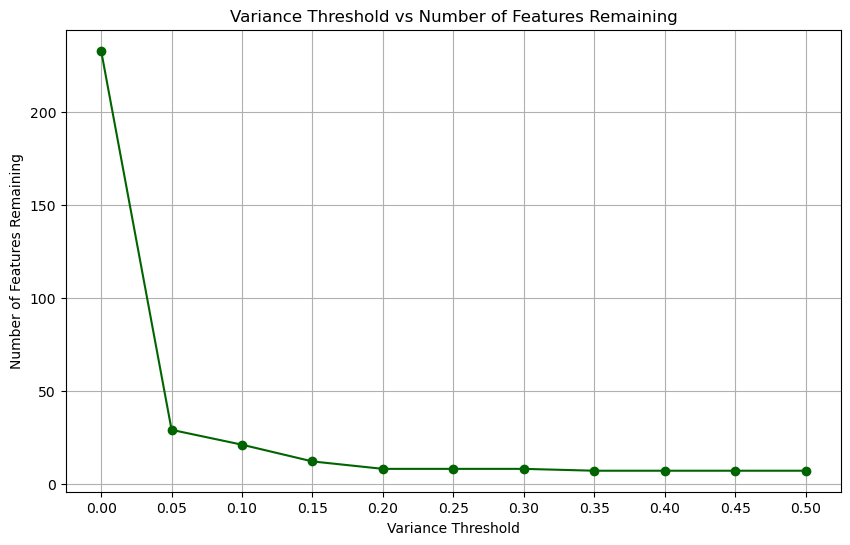

In [26]:
thresholds = np.arange(0.0, 0.55, 0.05)
features_per_threshold = {}
results = []
for t in thresholds:
    vt = VarianceThreshold(threshold=t)
    
    X_threshold = vt.fit_transform(pre_scaled_X)
    rows, cols = X_threshold.shape
    n_features = cols
    print('Threshold=%.2f, Features=%d' % (t, n_features))
    
    results.append(n_features)
    features_per_threshold[t] = vt.get_feature_names_out()
    
# Visualize Tradeoffs
plt.figure(figsize=(10, 6))
plt.plot(thresholds, results, marker='o', linestyle='-', color='darkgreen')
plt.title('Variance Threshold vs Number of Features Remaining')
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Features Remaining')
plt.grid(True)
plt.xticks(thresholds)  # optional: show exact threshold ticks
plt.show()


In [27]:
for t in features_per_threshold:
    print(f"\nThreshold {t:.2f}: {len(features_per_threshold[t])} features")
    print(features_per_threshold[t])


Threshold 0.00: 233 features
['group_id' 'num_requests' 'parent_closed' 'status_code' 'request_type_id'
 'origin' 'cross_street_id' 'latitude' 'longitude' 'year' 'dept_911'
 'dept_ACHD - Food Safety' 'dept_ACHD - Housing'
 'dept_Allegheny City Electric' 'dept_Animal Care & Control'
 'dept_City Clerks Office' 'dept_City Planning'
 'dept_City Planning - Bicycles/Pedestrian traffic'
 'dept_City Planning - Disabilities'
 'dept_City Planning - Residential Permit Parking Program'
 'dept_Commission on Human Relations' 'dept_DOMI - Asphalt'
 'dept_DOMI - Construction' 'dept_DOMI - Permits' 'dept_DOMI - Planning'
 'dept_DOMI - ROW' 'dept_DOMI - Streets' 'dept_DOMI - Structures'
 'dept_DOMI - Traffic' 'dept_DOMI - TrafficPermits'
 'dept_DOMI - TrafficShop' 'dept_DOMIAdministration'
 'dept_DPW - 2nd Division' 'dept_DPW - Administration'
 'dept_DPW - Construction Division' 'dept_DPW - Environmental Enforcement'
 'dept_DPW - Facilities' 'dept_DPW - Forestry Division'
 'dept_DPW - Park Maintenance'

## Principal Component Analysis

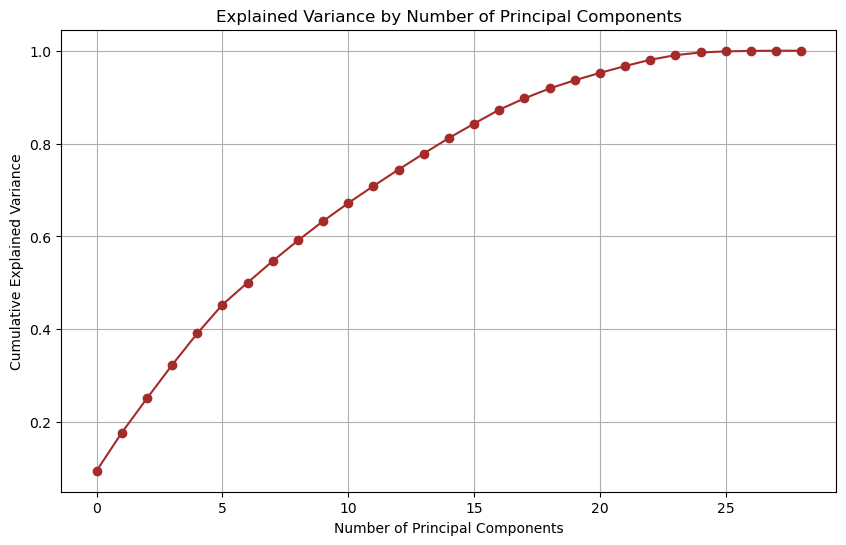

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_df_encoded[features_per_threshold[0.05]])

# Step 3: Implement and Visualize PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='brown')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()


In [41]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components that explain ≥85% variance
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Using {n_components} components to reach ≥90% variance.")

Using 19 components to reach ≥90% variance.


In [42]:
# Apply PCA with that number of components
pca_final = PCA(n_components=n_components)
X_reduced = pca_final.fit_transform(X_scaled)

## K-Means Application + Evaluation

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_reduced)

# Get the cluster assignments
clusters = kmeans.labels_


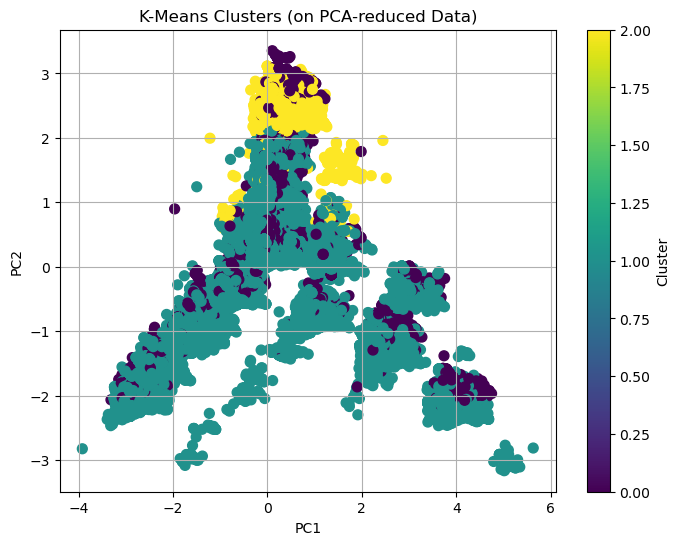

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters (on PCA-reduced Data)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

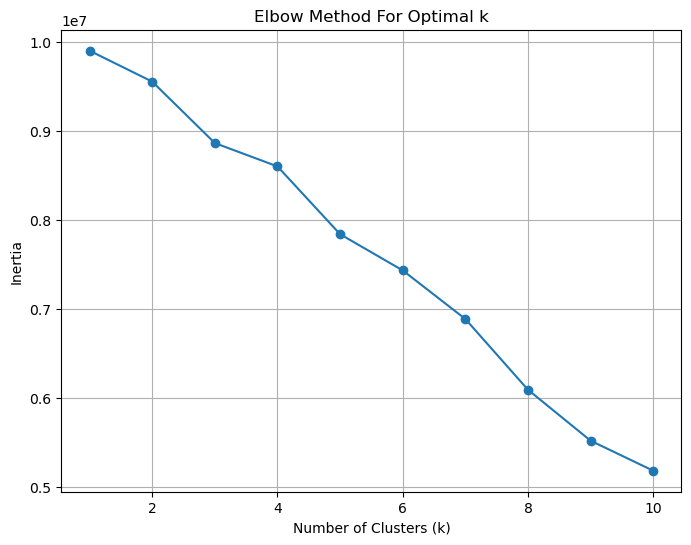

In [45]:
pca_df_encoded['Cluster'] = clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()
